In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [40]:
import requests
import json
from datetime import date, timedelta
from numpy import array
import pandas as pd
import nltk
from nltk.probability import FreqDist
from datetime import date, timedelta, datetime

import re, string
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('spanish')) 

stop_add=['con','com','media','excelsior','amp','ref','mx','5etfw','data','img']

for i in range(0,len(stop_add)):
    stop_words.add(stop_add[i])


#dfnotas = pd.read_csv('EXCELSIOR_ENERO_SEPTIEMBRE.csv')
dfnotas = pd.read_csv('Salud180.csv')
#dfnotas = pd.read_csv('NOTAS_EXCELSIOR_ENERO.csv')

[nltk_data] Downloading package stopwords to C:\Users\Diego
[nltk_data]     Esteva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#ELIMINA NOTAS SIN PVS
nulos=[]

#dfnotas['Número de vistas de página']=dfnotas['Número de vistas de página'].astype(int)
dfnotas = dfnotas.fillna(0)

for i in range(0,len(dfnotas.index)):
    if dfnotas.iloc[i]['Número de vistas de página']==0:
        nulos.append(i)

#dfnotas.drop([749], axis=0)

#AUN SE ESTA TRABAJANDO 

In [41]:
def limpiar_texto(texto):

    link_eliminar=[]
    link_ubi=[]
    acum=[]
    
    for i in range (0,len(texto)):  #Busca la posicion en el texto de los "<" y ">" 
        if '<' == texto[i]:
            link_ubi.append(i)
            
        elif  '>' == texto[i]:
            link_ubi.append(i)
            
            link_eliminar.append(link_ubi)
            link_ubi=[]
              
  #  print(link_eliminar)
    for i in range (0,len(link_eliminar)):  #recuperar lo que esta dentro de "<" y ">"(indexaciones,links,codigos,etc) y mete ese texto en una lista
        textoaux=texto[(link_eliminar[i])[0]:(link_eliminar[i])[1]+1]
        acum.append(textoaux)
    
    for i in range(0,len(acum)): #elimina todas las coincidencias de la lista que creamos en el ciclo anterior
        texto=texto.replace(acum[i],"")  
    
    return texto

In [42]:
def eliminar_caracteresesp(texto):

#    link_eliminar=[]
#    link_ubi=[]
#    acum=[]
#    
#    for i in range (0,len(texto)):  #Busca la posicion en el texto de los "<" y ">" 
#        if '<' == texto[i]:
#            link_ubi.append(i)
#            
#        elif  '>' == texto[i]:
#            link_ubi.append(i)
#            
#            link_eliminar.append(link_ubi)
#            link_ubi=[]
#              
#  #  print(link_eliminar)
#    for i in range (0,len(link_eliminar)):  #recuperar lo que esta dentro de "<" y ">"(indexaciones,links,codigos,etc) y mete ese texto en una lista
#        textoaux=texto[(link_eliminar[i])[0]:(link_eliminar[i])[1]+1]
#        acum.append(textoaux)
#    
#    for i in range(0,len(acum)): #elimina todas las coincidencias de la lista que creamos en el ciclo anterior
#        texto=texto.replace(acum[i],"")  
    
    
    texto=texto.lower()    #Hace minusculas todas las letras del cuerpo

    texto=re.sub('[%s]' % re.escape(string.punctuation), ' ', texto) #Elimina puntuacion

    auxtexto=nltk.word_tokenize(texto)
    auxtexto2=[]  

    for w in auxtexto:  #Elimina articulos gramaticales
        if w not in stop_words: 
            auxtexto2.append(w)
    return auxtexto2



In [43]:
no_palabras_titulo=[]
repetidas=[]
no_palabras_cuerpo=[]
no_letras_url=[]
diccionario_frecuencias = {}
mas_repetidasaux=''
mas_repetidas=[]
vocabulario_cuerpo =[]
frecuentes_cuerpo=[]
nuevo_cuerpo=[]
TieneKeyValue=[]
CountTags=[]
CountParrafos=[]
CountLinks=[]



#Convierte los datos en tipo necesario
dfnotas['title']=dfnotas['title'].astype(str) 
dfnotas['cuerpo']=dfnotas['cuerpo'].astype(str)
dfnotas['tags']=dfnotas['tags'].astype(str)
#dfnotas['Fecha'] = pd.to_datetime(dfnotas['Fecha'], format="%d/%m/%Y")

for i in range(0,len(dfnotas.index)):

    titulo=dfnotas.iloc[i]['title'] #recorre los titulos del dt por fila
    cuerpo=dfnotas.iloc[i]['cuerpo']

    tokens_titulo = nltk.word_tokenize(titulo) #separa el titulo por palabras
    
    no_letras_url.append(len(dfnotas.iloc[i]['url']))
    no_palabras_titulo.append(len(tokens_titulo))  #agrega a la lista la cantidad de palabras de cada titulo
    

    
    CountParrafos.append(dfnotas.iloc[i]['cuerpo'].count("<p>")-4) #Cuenta la cantidad de parrafos (-4 es por los parrafos que siempre estan implicitos en las notas)
    CountLinks.append(dfnotas.iloc[i]['cuerpo'].count("<a")) #Cuenta cantidad de links
    
    for palabra in tokens_titulo:                   #Agrega todas las palabras que se repitan mas de dos veces en el titulo
        if palabra in diccionario_frecuencias:
            diccionario_frecuencias[palabra] += 1
        else:
            diccionario_frecuencias[palabra] = 1

    for palabra in diccionario_frecuencias:
        frecuencia = diccionario_frecuencias[palabra]
    
        if frecuencia >= 2 : 
            mas_repetidas.append(palabra)
            mas_repetidasaux=mas_repetidasaux+palabra+","
    
    repetidas.append(mas_repetidas)
    mas_repetidas=[]
    diccionario_frecuencias = {}
    
    
    
######################################################################
#CONTEO DE TAGS
    
    if (dfnotas.iloc[i]['tags']) != 0 :
        TieneKeyValue.append('Si')
        CountTags.append(dfnotas.iloc[i]['tags'].count("_")+1) #cuantos Tags hay en la notas
        
    else:
        #TagsEsp.append("Null")
        CountTags.append(0)
        TieneKeyValue.append('No')
    
#####################################
#CONTEO DE PALABRAS FRECUENTES    

    cuerpo=limpiar_texto(cuerpo)
    nuevo_cuerpo.append(cuerpo)
    
    tokens_cuerpo = nltk.word_tokenize(cuerpo) #separa el cuerpo por palabras
    
    no_palabras_cuerpo.append(len(tokens_cuerpo))
    vocabulario_cuerpo.append(set(tokens_cuerpo))

    auxcuerpo2=eliminar_caracteresesp(cuerpo)

        
    frecuentes_cuerpo.append(FreqDist(auxcuerpo2).most_common(10)) #crea una lista con las 10 palabras mas frecuente del cuerpo y su no. de repeticiones

#Se añaden columnas con las nuevas metricas

dfnotas['cuerpo']=nuevo_cuerpo
dfnotas['No.Letras Url']=no_letras_url                  #cantidad de letras en url
dfnotas['No.Palabras Titulo']=no_palabras_titulo        #Cantidad de palabras en el titulo
dfnotas['Mas Frecuentes Titulo']=repetidas              #Palabras mas frecuentes en el titulo
dfnotas['No.Palabras Cuerpo']=no_palabras_cuerpo        #Cantidad de palabras en el cuerpo de la nota
dfnotas['No.Parrafos']=CountParrafos                    #Cantidad de parrafos en el cuerpo
dfnotas['No.Links']=CountLinks                          #Cantidad de de links en la nota
dfnotas['Vocabulario Cuerpo']=vocabulario_cuerpo        #Vocabulario usado en el cuerpo
dfnotas['Mas Frecuentes Cuerpo ']=frecuentes_cuerpo     #Palabras mas frecuente en el cuerpo
dfnotas['Tiene Tags']=TieneKeyValue                     #Dice se pusieron tags o no en la nota
dfnotas['No.Tags']=CountTags                            #Cantidad de tags en la nota

dfnotas.head(5)


,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página,No.Letras Url,No.Palabras Titulo,Mas Frecuentes Titulo,No.Palabras Cuerpo,No.Parrafos,No.Links,Vocabulario Cuerpo,Mas Frecuentes Cuerpo,Tiene Tags,No.Tags
0,salud180,"15 feb 2022, 23:19:22","68: la postura ""más ardiente"" del Kamasutra qu...",2022-02-15,18:19:22,https://www.salud180.com/bienestar180/68-la-po...,María Hernández Vera,_sexualidad_salud sexual_pareja_placer femenino,Se vale disfrutar nuevas cosas en el sexo y sa...,315770.0,124,25,[],477,8,5,"{antes, a, mucho, penetración, obtener, of, ca...","[(pareja, 5), (oxitocina, 4), (mujeres, 4), (d...",Si,5
1,salud180,"3 ene 2022, 19:38:32",La dieta de 1200 calorías del Dr. Nowzaradan e...,2022-01-03,14:38:32,https://www.salud180.com/nutricion-y-ejercicio...,Diana Oliva,_dieta_perder peso_bajar de peso_dieta 1200_ca...,Si algo nos ha dejado esta “infinita” cuarente...,216085.0,125,21,"[de, sí]",398,6,4,"{a, conecta, CLICK, consumo, 2, bolsa, bariátr...","[(“, 5), (”, 5), (dieta, 5), (kilos, 4), (dr, ...",Si,9
2,salud180,"25 may 2022, 14:07:50",Truco fácil y económico para destapar los aguj...,2022-05-25,9:07:50,https://www.salud180.com/salud-dia-a-dia/como-...,Diana Oliva,_regadera_coladera_tips de limpieza_limpiar re...,¿Los agujeros de tu regadera están tapados? Si...,165630.0,81,11,[],309,-3,1,"{a, ello, están, minerales, regresará, bolsa, ...","[(bolsa, 4), (agujeros, 3), (regadera, 3), (si...",Si,12
3,salud180,"3 ene 2022, 18:50:02",Cómo usar el vinagre en tu jardín para benefic...,2022-01-03,13:50:02,https://www.salud180.com/salud-dia-a-dia/como-...,María Hernández Vera,_plantas_cuidado de las plantas_plagas en las ...,Una de las sustancias con mejores propiedades ...,152063.0,122,15,[],501,11,3,"{hormiguero, antes, a, alejen, componentes, pr...","[(vinagre, 9), (plantas, 7), (gracias, 5), (ag...",Si,4
4,salud180,"12 jul 2022, 20:12:49",Cómo eliminar el óxido de las puertas y ventan...,2022-07-12,15:12:49,https://www.salud180.com/salud-dia-a-dia/como-...,Nancy Polvo Rosales,_Por qué se oxidan las ventanas_por qué se oxi...,La temporada de lluvias no solo trae problemas...,145630.0,123,15,[],745,-1,6,"{óxido, antes, pasos, a, ello, estado, alumini...","[(óxido, 16), (cómo, 7), (lluvias, 5), (superf...",Si,12


In [44]:
#dfnotas=dfnotas.drop(0)
dfnotas.head(2)

,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página,No.Letras Url,No.Palabras Titulo,Mas Frecuentes Titulo,No.Palabras Cuerpo,No.Parrafos,No.Links,Vocabulario Cuerpo,Mas Frecuentes Cuerpo,Tiene Tags,No.Tags
0,salud180,"15 feb 2022, 23:19:22","68: la postura ""más ardiente"" del Kamasutra qu...",2022-02-15,18:19:22,https://www.salud180.com/bienestar180/68-la-po...,María Hernández Vera,_sexualidad_salud sexual_pareja_placer femenino,Se vale disfrutar nuevas cosas en el sexo y sa...,315770.0,124,25,[],477,8,5,"{antes, a, mucho, penetración, obtener, of, ca...","[(pareja, 5), (oxitocina, 4), (mujeres, 4), (d...",Si,5
1,salud180,"3 ene 2022, 19:38:32",La dieta de 1200 calorías del Dr. Nowzaradan e...,2022-01-03,14:38:32,https://www.salud180.com/nutricion-y-ejercicio...,Diana Oliva,_dieta_perder peso_bajar de peso_dieta 1200_ca...,Si algo nos ha dejado esta “infinita” cuarente...,216085.0,125,21,"[de, sí]",398,6,4,"{a, conecta, CLICK, consumo, 2, bolsa, bariátr...","[(“, 5), (”, 5), (dieta, 5), (kilos, 4), (dr, ...",Si,9


In [45]:
topic=[]

for i in range(0,len(dfnotas.index)):
    
    link=dfnotas.iloc[i]['url']
    topicaux=''
    diagonal=0
    for letra in link :
        if letra == '/' :
            diagonal=diagonal+1
            continue
        if diagonal == 3 :
            topicaux=topicaux+letra
            continue
        if diagonal ==4:
            break
    if len(topicaux) < 20:
        topic.append(topicaux)
    else:
        topic.append('null')


#for i in range(0,len(topic)):
#    
#    if 'adrenalina' in topic[i] :
#        topic[i]=1
#    elif 'comunidad' in topic[i]:
#        topic[i]=2
#    elif 'funcion' in topic[i]:
#        topic[i]=5
#    elif 'nacional' in topic[i]:
#        topic[i]=3
#    elif 'global' in topic[i]:
#        topic[i]=4
#    elif 'trending' in topic[i]:
#        topic[i]=6
#    else:
#        topic[i]=0
        
dfnotas['Topic']=topic
dfnotas.head(3)

,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página,...,No.Palabras Titulo,Mas Frecuentes Titulo,No.Palabras Cuerpo,No.Parrafos,No.Links,Vocabulario Cuerpo,Mas Frecuentes Cuerpo,Tiene Tags,No.Tags,Topic
0,salud180,"15 feb 2022, 23:19:22","68: la postura ""más ardiente"" del Kamasutra qu...",2022-02-15,18:19:22,https://www.salud180.com/bienestar180/68-la-po...,María Hernández Vera,_sexualidad_salud sexual_pareja_placer femenino,Se vale disfrutar nuevas cosas en el sexo y sa...,315770.0,...,25,[],477,8,5,"{antes, a, mucho, penetración, obtener, of, ca...","[(pareja, 5), (oxitocina, 4), (mujeres, 4), (d...",Si,5,bienestar180
1,salud180,"3 ene 2022, 19:38:32",La dieta de 1200 calorías del Dr. Nowzaradan e...,2022-01-03,14:38:32,https://www.salud180.com/nutricion-y-ejercicio...,Diana Oliva,_dieta_perder peso_bajar de peso_dieta 1200_ca...,Si algo nos ha dejado esta “infinita” cuarente...,216085.0,...,21,"[de, sí]",398,6,4,"{a, conecta, CLICK, consumo, 2, bolsa, bariátr...","[(“, 5), (”, 5), (dieta, 5), (kilos, 4), (dr, ...",Si,9,null
2,salud180,"25 may 2022, 14:07:50",Truco fácil y económico para destapar los aguj...,2022-05-25,9:07:50,https://www.salud180.com/salud-dia-a-dia/como-...,Diana Oliva,_regadera_coladera_tips de limpieza_limpiar re...,¿Los agujeros de tu regadera están tapados? Si...,165630.0,...,11,[],309,-3,1,"{a, ello, están, minerales, regresará, bolsa, ...","[(bolsa, 4), (agujeros, 3), (regadera, 3), (si...",Si,12,salud-dia-a-dia


In [46]:
#CLASIFICACION DE HORARIO DE PUBLICACION
horario_publicacion=[]
solo_hora=[]

madrugada=datetime.strptime('00:00:00', '%H:%M:%S') #Convertimos strings a formato fecha
mañana=datetime.strptime('05:00:00', '%H:%M:%S')
tarde=datetime.strptime('12:00:00', '%H:%M:%S')
noche=datetime.strptime('19:00:00', '%H:%M:%S')

for i in range(0,len(dfnotas.index)):
    
    horarioaux=dfnotas.iloc[i]['Hora'] 
    horarioaux=datetime.strptime(horarioaux, '%H:%M:%S')
    solo_hora.append(horarioaux.hour) #Hace una lista con solo la hora de publiacion de las notas

    if horarioaux >= madrugada and horarioaux < mañana : #Se clasifican las notas segundo su hora de publicacion en, madrugada, mañana, tarde y noche
        horario_publicacion.append('Madrugada')
    elif horarioaux >= mañana and horarioaux < tarde :
        horario_publicacion.append('Mañana')
    elif horarioaux >= tarde and horarioaux < noche  :
        horario_publicacion.append('Tarde')
    elif horarioaux >= noche :
        horario_publicacion.append('Noche')
    else:
        horario_publicacion.append('0')
            
    
#   if horarioaux >= madrugada and horarioaux < mañana :
#       horario_publicacion.append(1)
#   elif horarioaux >= mañana and horarioaux < tarde :
#       horario_publicacion.append(2)
#   elif horarioaux >= tarde and horarioaux < noche  :
#       horario_publicacion.append(3)
#   elif horarioaux >= noche :
#       horario_publicacion.append(4)
#   else:
#       horario_publicacion.append(0)

dfnotas['Horario de Publicacion']=horario_publicacion #Clasificacion en madrugada, mañana....
dfnotas['Solo Hora']=solo_hora #Solo la hora, no cuenta minutos y segundos
dfnotas.head(5)


,sitio,created,title,Fecha,Hora,url,editor,tags,cuerpo,Número de vistas de página,...,No.Palabras Cuerpo,No.Parrafos,No.Links,Vocabulario Cuerpo,Mas Frecuentes Cuerpo,Tiene Tags,No.Tags,Topic,Horario de Publicacion,Solo Hora
0,salud180,"15 feb 2022, 23:19:22","68: la postura ""más ardiente"" del Kamasutra qu...",2022-02-15,18:19:22,https://www.salud180.com/bienestar180/68-la-po...,María Hernández Vera,_sexualidad_salud sexual_pareja_placer femenino,Se vale disfrutar nuevas cosas en el sexo y sa...,315770.0,...,477,8,5,"{antes, a, mucho, penetración, obtener, of, ca...","[(pareja, 5), (oxitocina, 4), (mujeres, 4), (d...",Si,5,bienestar180,Tarde,18
1,salud180,"3 ene 2022, 19:38:32",La dieta de 1200 calorías del Dr. Nowzaradan e...,2022-01-03,14:38:32,https://www.salud180.com/nutricion-y-ejercicio...,Diana Oliva,_dieta_perder peso_bajar de peso_dieta 1200_ca...,Si algo nos ha dejado esta “infinita” cuarente...,216085.0,...,398,6,4,"{a, conecta, CLICK, consumo, 2, bolsa, bariátr...","[(“, 5), (”, 5), (dieta, 5), (kilos, 4), (dr, ...",Si,9,null,Tarde,14
2,salud180,"25 may 2022, 14:07:50",Truco fácil y económico para destapar los aguj...,2022-05-25,9:07:50,https://www.salud180.com/salud-dia-a-dia/como-...,Diana Oliva,_regadera_coladera_tips de limpieza_limpiar re...,¿Los agujeros de tu regadera están tapados? Si...,165630.0,...,309,-3,1,"{a, ello, están, minerales, regresará, bolsa, ...","[(bolsa, 4), (agujeros, 3), (regadera, 3), (si...",Si,12,salud-dia-a-dia,Mañana,9
3,salud180,"3 ene 2022, 18:50:02",Cómo usar el vinagre en tu jardín para benefic...,2022-01-03,13:50:02,https://www.salud180.com/salud-dia-a-dia/como-...,María Hernández Vera,_plantas_cuidado de las plantas_plagas en las ...,Una de las sustancias con mejores propiedades ...,152063.0,...,501,11,3,"{hormiguero, antes, a, alejen, componentes, pr...","[(vinagre, 9), (plantas, 7), (gracias, 5), (ag...",Si,4,salud-dia-a-dia,Tarde,13
4,salud180,"12 jul 2022, 20:12:49",Cómo eliminar el óxido de las puertas y ventan...,2022-07-12,15:12:49,https://www.salud180.com/salud-dia-a-dia/como-...,Nancy Polvo Rosales,_Por qué se oxidan las ventanas_por qué se oxi...,La temporada de lluvias no solo trae problemas...,145630.0,...,745,-1,6,"{óxido, antes, pasos, a, ello, estado, alumini...","[(óxido, 16), (cómo, 7), (lluvias, 5), (superf...",Si,12,salud-dia-a-dia,Tarde,15


In [14]:
#VOCABULARIO POR TOPICS
topic=''
vocabulario_funcion=[]
vocabulario_adrenalina=[]
vocabulario_comunidad=[]
vocabulario_nacional=[]
vocabulario_global=[]
vocabulario_trending=[]
vocabularios=[]

for i in range(0,len(dfnotas.index)):
    
    topic=dfnotas.iloc[i]['Topic']
    
    if 'adrenalina' in topic :
        vocabulario_adrenalina=vocabulario_adrenalina+list(set(eliminar_caracteresesp(limpiar_texto(dfnotas.iloc[i]['cuerpo'])))) #la funcion set devuelve un conjunto, por lo que lo transformamos a lista(list()) para poder sumarlo
    elif 'comunidad' in topic:
        vocabulario_comunidad=vocabulario_comunidad+list(set(eliminar_caracteresesp(limpiar_texto(dfnotas.iloc[i]['cuerpo']))))
    elif 'funcion' in topic:
        vocabulario_funcion=vocabulario_funcion+list(set(eliminar_caracteresesp(limpiar_texto(dfnotas.iloc[i]['cuerpo']))))
    elif 'nacional' in topic:
        vocabulario_nacional=vocabulario_nacional+list(set(eliminar_caracteresesp(limpiar_texto(dfnotas.iloc[i]['cuerpo']))))
    elif 'global' in topic:
        vocabulario_global=vocabulario_global+list(set(eliminar_caracteresesp(limpiar_texto(dfnotas.iloc[i]['cuerpo']))))
    elif 'trending' in topic:
        vocabulario_trending=vocabulario_trending+list(set(eliminar_caracteresesp(limpiar_texto(dfnotas.iloc[i]['cuerpo']))))

topics=['adrenalidad','comunidad','funcion','nacional','global','trending']
        
vocabularios.append(FreqDist(vocabulario_adrenalina).most_common(10))
vocabularios.append(FreqDist(vocabulario_comunidad).most_common(10))
vocabularios.append(FreqDist(vocabulario_funcion).most_common(10))
vocabularios.append(FreqDist(vocabulario_nacional).most_common(10))
vocabularios.append(FreqDist(vocabulario_global).most_common(10))
vocabularios.append(FreqDist(vocabulario_trending).most_common(10))



dfvocabularios=pd.DataFrame()

dfvocabularios['Topics']=topics
dfvocabularios['Vocabulario Global']=vocabularios

dfvocabularios.head()


,Topics,Vocabulario Global
0,adrenalidad,"[(equipo, 394), (dos, 385), (partido, 359), (2..."
1,comunidad,"[(méxico, 710), (ciudad, 661), (trámite, 562),..."
2,funcion,"[(años, 213), (ver, 189), (”, 170), (ser, 145)..."
3,nacional,"[(”, 903), (“, 773), (méxico, 714), (nacional,..."
4,global,"[(dijo, 369), (según, 325), (país, 291), (unid..."


In [35]:
#dfadrenalina=pd.DataFrame()
#
#for i in range(0,len(dfnotas.index)):
#    if dfnotas.iloc[i]['Topic']=='adrenalina':
#        dfadrenalina.concat(dfnotas.loc[i])


In [33]:
dfadrenalina.head()

""


In [47]:
dfnotas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sitio                       1761 non-null   object 
 1   created                     1761 non-null   object 
 2   title                       1761 non-null   object 
 3   Fecha                       1761 non-null   object 
 4   Hora                        1761 non-null   object 
 5   url                         1761 non-null   object 
 6   editor                      1761 non-null   object 
 7   tags                        1761 non-null   object 
 8   cuerpo                      1761 non-null   object 
 9   Número de vistas de página  1731 non-null   float64
 10  No.Letras Url               1761 non-null   int64  
 11  No.Palabras Titulo          1761 non-null   int64  
 12  Mas Frecuentes Titulo       1761 non-null   object 
 13  No.Palabras Cuerpo          1761 

In [51]:
dfnotas.describe()

,id,created,Número de vistas de página,No.Letras Url,No.Palabras Titulo,No.Palabras Cuerpo,No.Parrafos,No.Links,No.Tags,Topic,Horario de Publicacion
count,7.500000e+02,7.500000e+02,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,1.538423e+06,1.662771e+09,1495.828000,107.553333,12.254667,698.548000,9.470667,4.844000,3.845333,3.102667,3.705333
std,2.778440e+03,3.742760e+05,4834.776261,12.936188,3.604321,435.491171,8.334052,6.520456,1.740915,1.637794,0.456197
min,1.490588e+06,1.662157e+09,0.000000,64.000000,3.000000,1.000000,-4.000000,0.000000,1.000000,0.000000,3.000000
25%,1.537663e+06,1.662432e+09,144.000000,98.000000,10.000000,476.250000,5.000000,2.000000,3.000000,2.000000,3.000000
50%,1.538652e+06,1.662770e+09,330.000000,107.000000,12.000000,614.000000,8.000000,4.000000,4.000000,3.000000,4.000000
75%,1.539412e+06,1.663118e+09,839.000000,118.000000,14.000000,812.250000,12.000000,6.000000,5.000000,4.000000,4.000000
max,1.540113e+06,1.663389e+09,62408.000000,132.000000,48.000000,5064.000000,108.000000,132.000000,9.000000,6.000000,4.000000


Saving figure attribute_histogram_plots


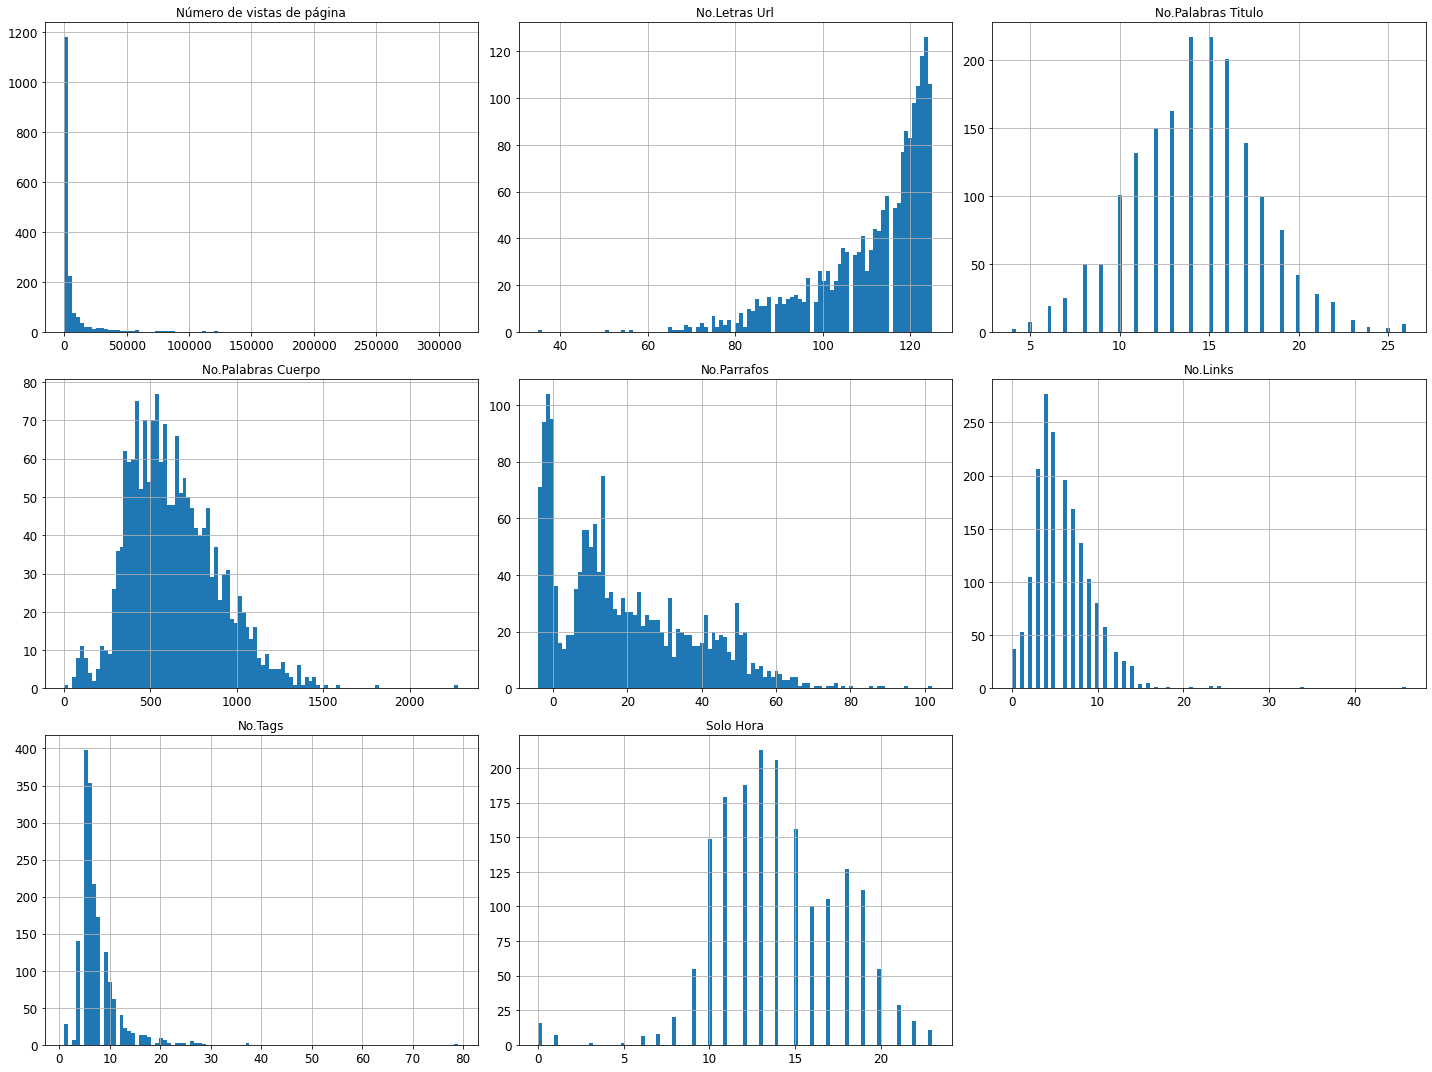

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
dfnotas.hist(bins=100, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [49]:
dfnotas
corr_matrix = dfnotas.corr()
corr_matrix['Número de vistas de página'].sort_values(ascending=False)

Número de vistas de página    1.000000
No.Palabras Titulo            0.125729
No.Letras Url                 0.113319
No.Links                      0.043593
Solo Hora                     0.037586
No.Tags                       0.017782
No.Palabras Cuerpo           -0.038862
No.Parrafos                  -0.098943
Name: Número de vistas de página, dtype: float64

Saving figure attribute_histogram_plots


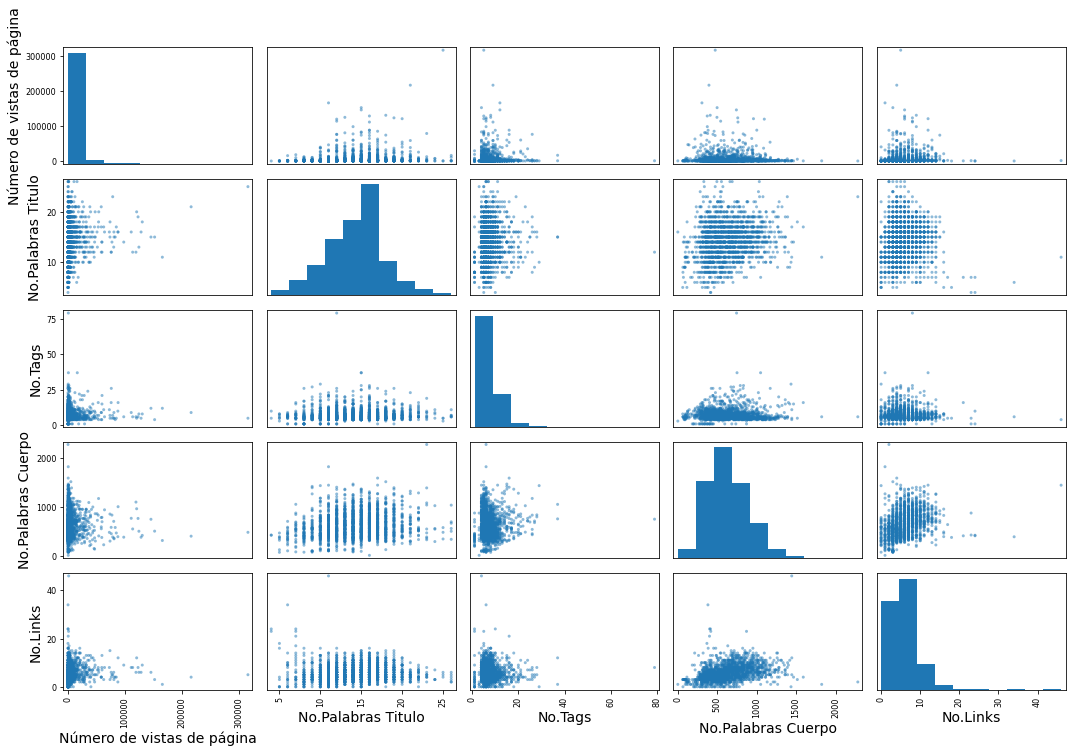

In [56]:
from pandas.plotting import scatter_matrix

attributes = ["Número de vistas de página", "No.Palabras Titulo","No.Tags","No.Palabras Cuerpo","created","No.Links"]
scatter_matrix(dfnotas[attributes], figsize=(15, 10))
save_fig("attribute_histogram_plots")

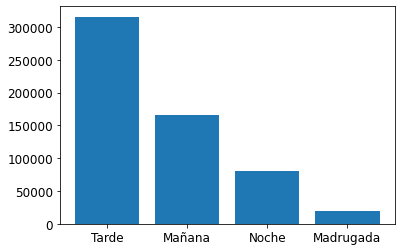

In [51]:
plt.bar( dfnotas['Horario de Publicacion'], dfnotas['Número de vistas de página'])
plt.show()


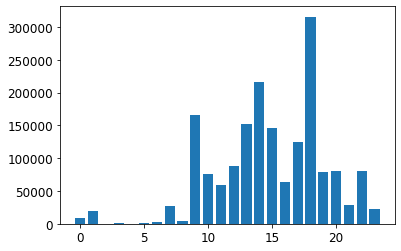

In [52]:
plt.bar( dfnotas['Solo Hora'], dfnotas['Número de vistas de página'])
plt.show()


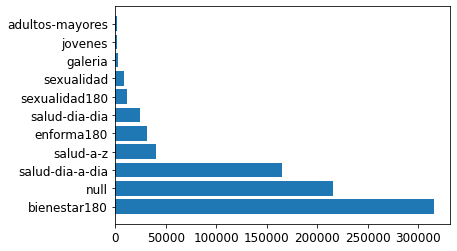

In [53]:
plt.barh( dfnotas['Topic'], dfnotas['Número de vistas de página'])
plt.show()


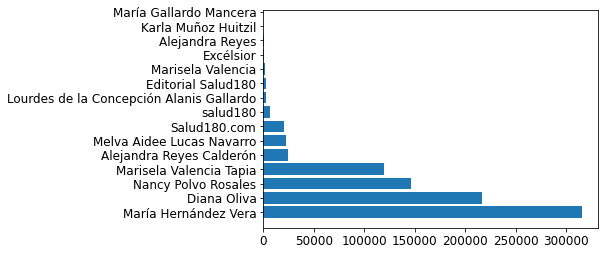

In [54]:
plt.barh( dfnotas['editor'], dfnotas['Número de vistas de página'])
plt.show()


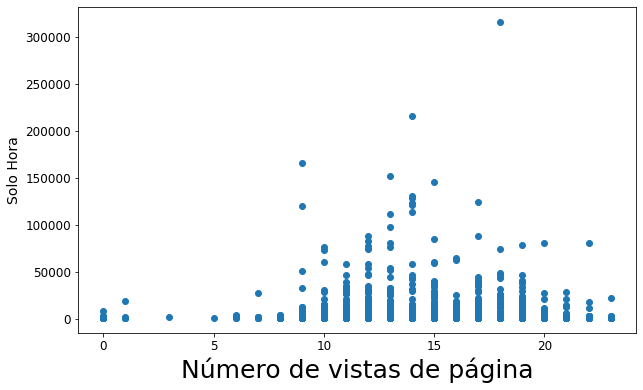

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))

x_values = dfnotas["Solo Hora"].unique()

ax.scatter(x = dfnotas["Solo Hora"], y = dfnotas["Número de vistas de página"])
plt.xlabel("Número de vistas de página",fontsize=25)
plt.ylabel("Solo Hora")

plt.show()

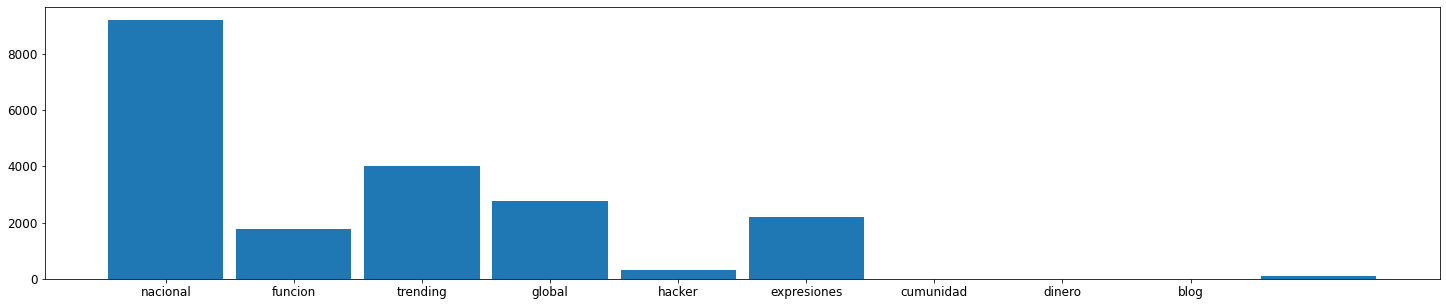

In [90]:
plt.rcParams["figure.figsize"] = (25, 5)
plt.xticks(np.arange(0.7, 12, step=1.4))
plt.hist( dfnotas['Topic'],rwidth=0.9)

plt.show()
